# 加载数据集

In [1]:
from datasets import load_dataset
from collections import Counter

dataset = load_dataset('conll2003')
print(len(dataset['train']), len(dataset['test']), len(dataset['validation']))
print(f"训练集中标签统计: {Counter(t for tags in dataset['train']['tags'] for t in tags)}")
print(f"测试集中标签统计: {Counter(t for tags in dataset['test']['tags'] for t in tags)}")
print(f"验证集中标签统计: {Counter(t for tags in dataset['validation']['tags'] for t in tags)}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

14041 3453 3250
训练集中标签统计: Counter({0: 169575, 5: 7140, 3: 6600, 1: 6321, 4: 4528, 6: 3704, 2: 3438, 8: 1157, 7: 1155})
测试集中标签统计: Counter({0: 38315, 5: 1668, 1: 1661, 3: 1617, 4: 1156, 6: 835, 2: 702, 8: 257, 7: 216})
验证集中标签统计: Counter({0: 42757, 3: 1842, 5: 1837, 1: 1341, 4: 1307, 2: 922, 6: 751, 7: 346, 8: 257})


In [2]:
label2id = {
          "O": 0,
          "B-ORG": 1,
          "B-MISC": 2,
          "B-PER": 3,
          "I-PER": 4,
          "B-LOC": 5,
          "I-ORG": 6,
          "I-MISC": 7,
          "I-LOC": 8}
id2label = {v: k for k, v in label2id.items()}

训练集中最大token列表长度: 113, 测试集中最大token列表长度: 124, 验证集中最大token列表长度: 109 .


(array([8.129e+03, 2.641e+03, 2.208e+03, 9.210e+02, 1.280e+02, 1.200e+01,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  12.2,  23.4,  34.6,  45.8,  57. ,  68.2,  79.4,  90.6,
        101.8, 113. ]),
 <BarContainer object of 10 artists>)

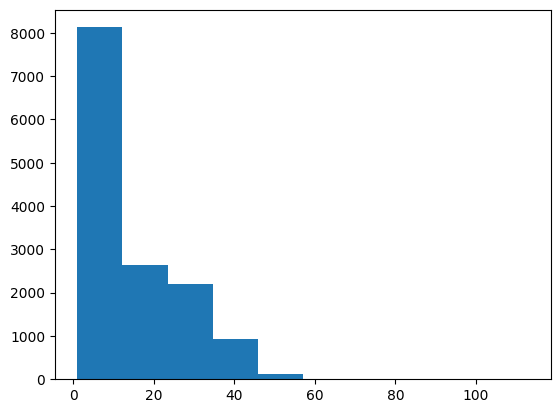

In [17]:
import matplotlib.pyplot as plt

print(f"训练集中最大token列表长度: {max(len(t) for t in dataset['train']['tokens'])}, "
        f"测试集中最大token列表长度: {max(len(t) for t in dataset['test']['tokens'])}, "
        f"验证集中最大token列表长度: {max(len(t) for t in dataset['validation']['tokens'])} .")
plt.hist(list(len(t) for t in dataset['train']['tokens']))

# 使用训练集训练词向量

In [18]:
from gensim.models import word2vec

model = word2vec.Word2Vec(sentences=dataset['train']['tokens'], vector_size=512, sg=1, min_count=1)
model.save("/root/autodl-tmp/ner/conll2003_word_vec_sg.bin")

# 因子分析

In [19]:
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
import seaborn as sns
import math
from gensim.models import word2vec
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

In [20]:
# 加载训练好的word2vec模型
model = word2vec.Word2Vec.load("/root/autodl-tmp/ner/conll2003_word_vec_sg.bin")
embedding = np.array([model.wv[word] for word in model.wv.index_to_key])
print(embedding.shape)

(23622, 512)


In [21]:
# Bartlett's球状检验
print('Bartlett\'s球状检验: 检验总体变量的相关矩阵是否是单位阵')
chi_square_value, p_value = calculate_bartlett_sphericity(embedding)
print(chi_square_value, p_value)

# 导入kmo检验
print('kmo检验:')
print('检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好')
kmo_all, kmo_model = calculate_kmo(embedding)
print('KMO值为: ', kmo_model)

Bartlett's球状检验: 检验总体变量的相关矩阵是否是单位阵
inf 0.0
kmo检验:
检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/factor_analyzer.py:108: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


KMO值为:  0.999157674744419


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [22]:
# 因子分析
fa = FactorAnalyzer(25, rotation=None)
# fa = FactorAnalyzer(25, rotation='varimax')
fa.fit(embedding)

# 特征值、特征向量
ev, v = fa.get_eigenvalues()

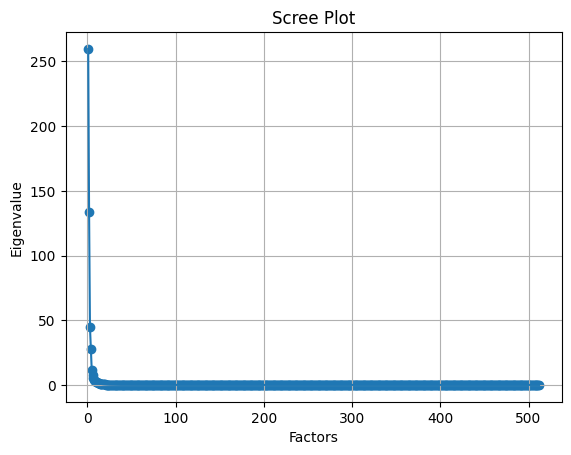

In [23]:
# 可视化
# plot横轴是指标个数，纵轴是ev值
plt.scatter(range(1, embedding.shape[1]+1), ev)
plt.plot(range(1, embedding.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

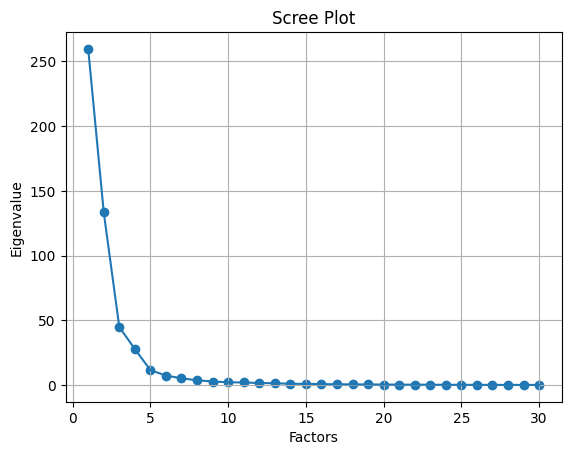

<Figure size 640x480 with 0 Axes>

In [25]:
# 更清晰的展示前三十个
plt.scatter(range(1, 31), ev[:30])
plt.plot(range(1, 31), ev[:30])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
plt.savefig('ev30.png')

In [26]:
# 上图表示，八个因子已经承载了足够多的特征值，确定因子数为8进行因子分析
fa = FactorAnalyzer(8, rotation="promax")
fa.fit(embedding)
print(fa.loadings_.shape)

# 保存因子分析的结果
# 512*8(变量个数*因子个数)
index = fa.loadings_.argmax(axis=1)
res = np.array([[i, idx] for i, idx in enumerate(index)])

data_1 = pd.DataFrame(fa.loadings_, columns=['fa1', 'fa2', 'fa3', 'fa4', 'fa5', 'fa6', 'fa7', 'fa8'])
data_2 = pd.DataFrame(res, columns=['Dimension', 'Factor'])
with pd.ExcelWriter("FAoutput.xlsx") as writer1:
    data_1.to_excel(writer1, sheet_name="Sheet1")
    data_2.to_excel(writer1, sheet_name="Sheet2")
    writer1.save()

(512, 8)


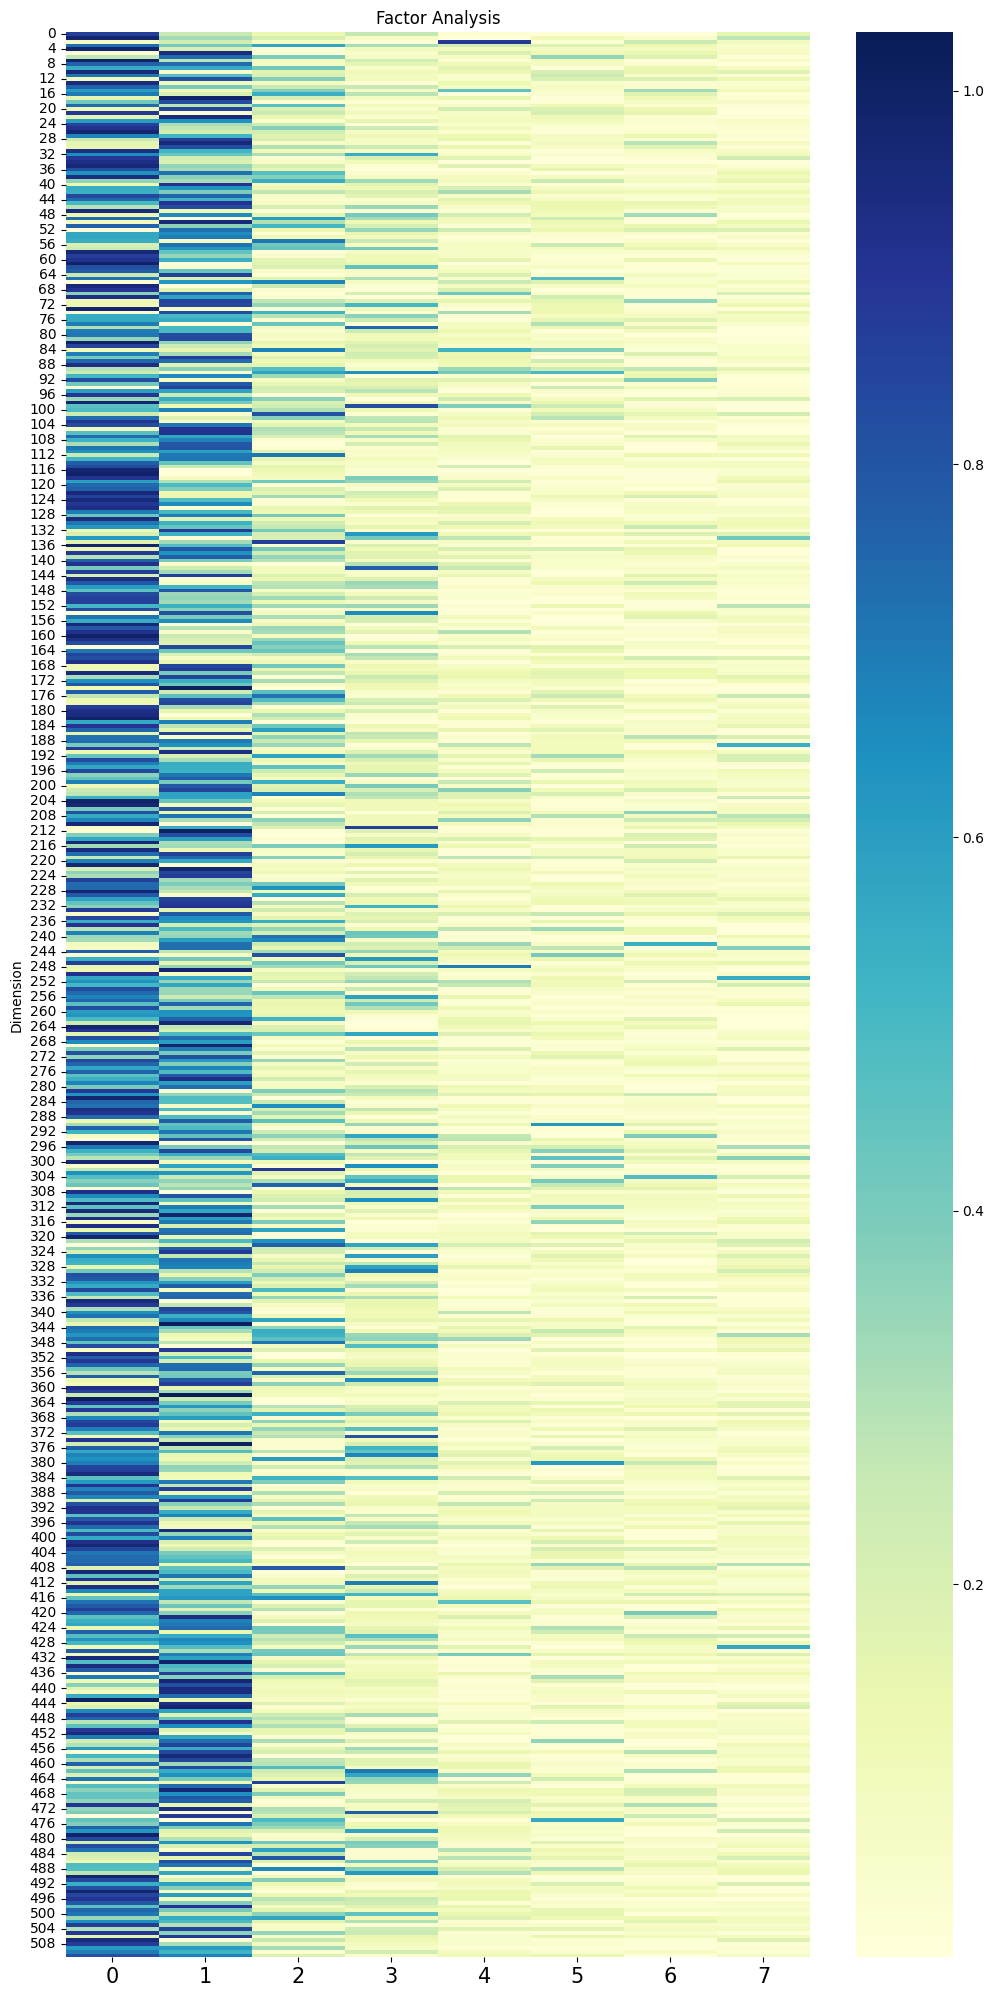

In [27]:
# 因子分析结果可视化
df_cm = pd.DataFrame(np.abs(fa.loadings_))
fig, ax = plt.subplots(figsize=(12, 25))
sns.heatmap(df_cm, annot=None, cmap='YlGnBu', ax=ax)  # cbar_kws

ax.tick_params(axis='x', labelsize=15)
ax.set_title("Factor Analysis", fontsize=12)
ax.set_ylabel("Dimension")
plt.savefig('FAdimension.png')

# 模型架构

In [3]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import time
import math
from gensim.models import word2vec

## FAM

In [4]:
class FAMAttention(nn.Module):
    """修改多头注意力，针对嵌入512维，8个head的模型"""

    def __init__(self, num_hiddens, dim_dict, dropout, bias=False, **kwargs):
        super(FAMAttention, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.dim_dict = dim_dict
        self.dim_0 = [dim for dim, idx in self.dim_dict.items() if idx == 0]
        self.dim_1 = [dim for dim, idx in self.dim_dict.items() if idx == 1]
        self.dim_2 = [dim for dim, idx in self.dim_dict.items() if idx == 2]
        self.dim_3 = [dim for dim, idx in self.dim_dict.items() if idx == 3]
        self.dim_4 = [dim for dim, idx in self.dim_dict.items() if idx == 4]
        self.dim_5 = [dim for dim, idx in self.dim_dict.items() if idx == 5]
        self.dim_6 = [dim for dim, idx in self.dim_dict.items() if idx == 6]
        self.dim_7 = [dim for dim, idx in self.dim_dict.items() if idx == 7]
        # self.list_concat = torch.cat((self.dim_0, self.dim_1, self.dim_2, self.dim_3, self.dim_4, self.dim_5,
        # self.dim_6, self.dim_7))
        self.len_0, self.len_1, self.len_2, self.len_3, self.len_4, self.len_5, self.len_6, self.len_7 = len(
            self.dim_0), len(self.dim_1), len(self.dim_2), len(self.dim_3), len(self.dim_4), len(self.dim_5),\
            len(self.dim_6), len(self.dim_7)

        self.Wq0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wq1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wq2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wq3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wq4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wq5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wq6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wq7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wk0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wk1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wk2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wk3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wk4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wk5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wk6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wk7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wv0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wv1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wv2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wv3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wv4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wv5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wv6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wv7 = nn.Linear(self.len_7, self.len_7, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        def assemble(output_concat, list_concat):
            reslist = []
            for i in range(512):
                reslist.append(list_concat.index(i))
            return torch.index_select(output_concat, -1, torch.tensor(reslist, device=output_concat.device))

        # queries, keys, values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # qi, ki, vi的形状：(batch_size, 查询或者“键－值”对的个数， self.len_i)
        q0, k0, v0 = torch.index_select(queries, -1, torch.tensor(self.dim_0, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_0, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_0, device=values.device))
        q1, k1, v1 = torch.index_select(queries, -1, torch.tensor(self.dim_1, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_1, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_1, device=values.device))
        q2, k2, v2 = torch.index_select(queries, -1, torch.tensor(self.dim_2, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_2, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_2, device=values.device))
        q3, k3, v3 = torch.index_select(queries, -1, torch.tensor(self.dim_3, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_3, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_3, device=values.device))
        q4, k4, v4 = torch.index_select(queries, -1, torch.tensor(self.dim_4, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_4, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_4, device=values.device))
        q5, k5, v5 = torch.index_select(queries, -1, torch.tensor(self.dim_5, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_5, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_5, device=values.device))
        q6, k6, v6 = torch.index_select(queries, -1, torch.tensor(self.dim_6, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_6, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_6, device=values.device))
        q7, k7, v7 = torch.index_select(queries, -1, torch.tensor(self.dim_7, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_7, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_7, device=values.device))

        head0 = self.attention(self.Wq0(q0), self.Wk0(k0), self.Wv0(v0), valid_lens)
        head1 = self.attention(self.Wq1(q1), self.Wk1(k1), self.Wv1(v1), valid_lens)
        head2 = self.attention(self.Wq2(q2), self.Wk2(k2), self.Wv2(v2), valid_lens)
        head3 = self.attention(self.Wq3(q3), self.Wk3(k3), self.Wv3(v3), valid_lens)
        head4 = self.attention(self.Wq4(q4), self.Wk4(k4), self.Wv4(v4), valid_lens)
        head5 = self.attention(self.Wq5(q5), self.Wk5(k5), self.Wv5(v5), valid_lens)
        head6 = self.attention(self.Wq6(q6), self.Wk6(k6), self.Wv6(v6), valid_lens)
        head7 = self.attention(self.Wq7(q7), self.Wk7(k7), self.Wv7(v7), valid_lens)

        output_concat = torch.cat((head0, head1, head2, head3, head4, head5, head6, head7), dim=-1)
        list_concat = self.dim_0 + self.dim_1 + self.dim_2 + self.dim_3 + self.dim_4 + self.dim_5 + self.dim_6 + self.dim_7
        return self.W_o(assemble(output_concat, list_concat))

In [5]:
# 编码器块
class EncoderBlock(nn.Module):
    """修改的编码器块"""

    def __init__(self, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = FAMAttention(num_hiddens, dim_dict, dropout, use_bias)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [6]:
# 编码器
class FAMforNER(d2l.Encoder):
    """修改的编码器"""

    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, num_layers, dropout, num_output,
                 use_bias=False, **kwargs):
        super(FAMforNER, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        self.outhidden = nn.Sequential(
                                    nn.Linear(num_hiddens, num_hiddens),
                                    nn.ReLU(),
                                    nn.Linear(num_hiddens, num_output))
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 EncoderBlock(num_hiddens, norm_shape, ffn_num_input,
                                              ffn_num_hiddens, dim_dict, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return self.outhidden(X)

## Baseline

In [4]:
class BaseforNER(d2l.Encoder):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, num_output, use_bias=False, **kwargs):
        super(BaseforNER, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        self.outhidden = nn.Sequential(
                                    nn.Linear(num_hiddens, num_hiddens),
                                    nn.ReLU(),
                                    nn.Linear(num_hiddens, num_output),
                                    nn.Softmax(dim=-1))
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                d2l.EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        # 取句首'cls'token的向量用于情感分类
        return self.outhidden(X)

# 生成训练、测试和验证数据集

In [5]:
vocab = d2l.Vocab(dataset['train']['tokens'], min_freq=1, reserved_tokens=['<pad>', '<cls>'])
print('词表大小: ', len(vocab))
print('前50个token: ', vocab.idx_to_token[:50])

词表大小:  23625
前50个token:  ['<unk>', '<pad>', '<cls>', '.', ',', 'the', 'of', 'in', 'to', 'a', '-LPR-', '-RPR-', 'and', '"', 'on', 'said', "'s", 'for', '1', '-', 'The', 'was', '2', '0', '3', 'at', 'with', 'that', 'from', 'by', 'is', ':', 'as', 'he', '4', 'had', 'has', 'it', 'his', 'not', 'were', 'be', 'an', 'have', 'after', 'who', 'will', '5', 'but', 'first']


In [14]:
vocab[dataset['train']['tokens'][0]]

[959, 11984, 235, 764, 8, 4149, 211, 6184, 3]

In [6]:
# 每条数据包括: (语句词元, 语句有效长度, 标签)
def load_conll_data(vocab, dataset, batch_size, num_steps):
    data_tokens = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in dataset['tokens']])
    valid_lens = (data_tokens != vocab['<pad>']).type(torch.int32).sum(1)
    # labels = torch.tensor(dataset[:]['label'])
    labels = torch.tensor([d2l.truncate_pad(tags, num_steps, 0) for tags in dataset['tags']])
    return d2l.load_array((data_tokens, valid_lens, labels), batch_size)


batch_size, num_steps = 64, 60
train_iter = load_conll_data(vocab, dataset['train'], batch_size, num_steps)
for X, valid_len, y in train_iter:
    print('X:', X.shape, ', y:', y.shape, ', valid_len:', valid_len.shape)
    break
print('小批量数目：', len(train_iter))

X: torch.Size([64, 60]) , y: torch.Size([64, 60]) , valid_len: torch.Size([64])
小批量数目： 220


In [7]:
test_iter = load_conll_data(vocab, dataset['test'], batch_size, num_steps)
validation_iter = load_conll_data(vocab, dataset['validation'], batch_size, num_steps)

# 实验准备

## 参数、超参数、读取必要文件

In [49]:
# 参数和超参数
# num_output 是实体标签类别数
num_hiddens, num_layers, dropout, num_output = 512, 3, 0.1, 9
ffn_num_input, ffn_num_hiddens, num_heads, norm_shape = 512, 2048, 8, [512]
lr, num_epochs, device = 5e-5, 100, torch.device('cuda')
key_size, query_size, value_size = 512, 512, 512

In [9]:
# 结果保存目录
file_path = '/root/autodl-tmp/ner/'

In [12]:
# 因子分析结果
excelfile = pd.read_excel(file_path + 'FAoutput.xlsx', sheet_name='Sheet2', header=0, index_col=0)
dim_dict = dict()
for i in range(512):
    dim_dict[excelfile['Dimension'].values[i]] = excelfile['Factor'].values[i]

## 实例化和初始化模型

In [50]:
# 实例化模型, 打印模型参数数量
net = BaseforNER(
    len(vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout, num_output)

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

21,814,281 total parameters.
21,814,281 training parameters.


In [14]:
for name, p in net.named_parameters():
    print(name)

embedding.weight
blks.block0.attention.W_q.weight
blks.block0.attention.W_k.weight
blks.block0.attention.W_v.weight
blks.block0.attention.W_o.weight
blks.block0.addnorm1.ln.weight
blks.block0.addnorm1.ln.bias
blks.block0.ffn.dense1.weight
blks.block0.ffn.dense1.bias
blks.block0.ffn.dense2.weight
blks.block0.ffn.dense2.bias
blks.block0.addnorm2.ln.weight
blks.block0.addnorm2.ln.bias
blks.block1.attention.W_q.weight
blks.block1.attention.W_k.weight
blks.block1.attention.W_v.weight
blks.block1.attention.W_o.weight
blks.block1.addnorm1.ln.weight
blks.block1.addnorm1.ln.bias
blks.block1.ffn.dense1.weight
blks.block1.ffn.dense1.bias
blks.block1.ffn.dense2.weight
blks.block1.ffn.dense2.bias
blks.block1.addnorm2.ln.weight
blks.block1.addnorm2.ln.bias
blks.block2.attention.W_q.weight
blks.block2.attention.W_k.weight
blks.block2.attention.W_v.weight
blks.block2.attention.W_o.weight
blks.block2.addnorm1.ln.weight
blks.block2.addnorm1.ln.bias
blks.block2.ffn.dense1.weight
blks.block2.ffn.dense1.bi

In [51]:
# 用word2vector训练的词向量来初始化embedding层模型权重
def get_embedding_weights(vocab, word2vecmodel, num_hiddens):
    wordlist = word2vecmodel.wv.index_to_key
    n = len(vocab)
    data = np.random.randn(n, num_hiddens)
    for i in range(n):
        word = vocab.idx_to_token[i]
        data[i] = np.array(word2vecmodel.wv[word]) if word in wordlist else data[i]
    return torch.tensor(data, dtype=torch.float32)


def init_embedding_weights(net, weights):
    for m in net.modules():
        if isinstance(m, nn.Embedding):
            m.weight.data = weights


word2vecmodel = word2vec.Word2Vec.load(file_path + 'conll2003_word_vec_sg.bin')
weights = get_embedding_weights(vocab, word2vecmodel, num_hiddens)
init_embedding_weights(net, weights)

# 用Xavier初始化线性层权重
for m in net.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

In [16]:
net.eval()
net(X, valid_len).shape

torch.Size([64, 60, 9])

In [17]:
nn.functional.cross_entropy(net(X, valid_len).view(-1, num_output), y.view(-1))

tensor(2.2299, grad_fn=<NllLossBackward0>)

## 评估函数

In [24]:
# 定义评估模型准确率和 F1 指标的函数
from sklearn.metrics import accuracy_score, f1_score
# f1_score(labels, predicitons, average='micro')
def evaluate_accuracy_f1(net, data_iter, device=None):
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device

    y_pred, y_true = torch.tensor([], device=device), torch.tensor([], device=device)
    with torch.no_grad():
        for data in data_iter:
            if isinstance(data, list) or isinstance(data, tuple):
                X, valid_len, y = [x.to(device) for x in data]
            else:
                X = X.to(device)
            y_pred = torch.cat([y_pred, net(X, valid_len).argmax(dim=-1).view(-1)])
            y_true = torch.cat([y_true, y.view(-1)])
    return accuracy_score(y_pred.cpu(), y_true.cpu()), f1_score(y_pred.cpu(), y_true.cpu(), average='macro')

In [46]:
evaluate_accuracy_f1(net, test_iter, device='cpu')

(0.061733758084757215, 0.013674394877504452)

# 模型训练

## 训练 1 (2 layer baseline)

### 前 100 epoch

In [32]:
# 带权重的损失函数
tags_cnt = Counter(t for tags in dataset['train']['tags'] for t in tags)
weights = [max(tags_cnt.values()) / tags_cnt[k] for k in sorted(tags_cnt.keys())]
print(weights)
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(reduction='none', weight=class_weights)

[1.0, 26.827242524916944, 49.32373472949389, 25.693181818181817, 37.45030918727915, 23.75, 45.78158747300216, 146.8181818181818, 146.56439066551425]


In [33]:
# trainer = torch.optim.Adam(params=net.parameters(), lr=lr)
# 为不同层赋予不同的学习率
forward_params = [
                param for name, param in net.named_parameters()
                if name != "embedding.weight"]
trainer = torch.optim.Adam(
                        [{'params': net.embedding.parameters()},
                         {'params': forward_params, 'lr': lr * 10}], lr=lr)

In [34]:
# 18,663,945 total parameters
net.to(device)
num_batches = len(train_iter)
losses, train_accuracy, test_accuracy, valid_accuracy = [], [], [], []
train_f1, test_f1, valid_f1 = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        X, valid_len, y = [v.to(device) for v in data]
        l = criterion(net(X, valid_len).view(-1, num_output), y.view(-1))
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 =evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, test_iter)
    epochvalidacc, epochvalidf1 = evaluate_accuracy_f1(net, validation_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, valid_acc {epochvalidacc:.3f}, '
        f'valid_f1 {epochvalidf1:.3f}, taking {round(end_time - start_time)} seconds.')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
    valid_accuracy.append(epochvalidacc)
    valid_f1.append(epochvalidf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失: {losses[-1]:.3f}, 训练集准确率: {train_accuracy[-1]:.3f}, '
     f'训练集f1: {train_f1[-1]:.3f}, 测试集准确率: {test_accuracy[-1]:.3f}, '
     f'测试集f1: {test_f1[-1]:.3f}, 验证集准确率: {valid_accuracy[-1]:.3f}, '
     f'验证集f1: {valid_f1[-1]:.3f}, 在设备 {device} 上训练 {num_epochs} 周期, 耗时 {total_timecost} s')

100%|██████████| 220/220 [00:03<00:00, 64.43it/s]


epoch 1, loss 292.792, train_acc 0.895, train_f1 0.193, test_acc 0.850, test_f1 0.147, valid_acc 0.839, valid_f1 0.158, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.61it/s]


epoch 2, loss 292.332, train_acc 0.795, train_f1 0.162, test_acc 0.801, test_f1 0.139, valid_acc 0.769, valid_f1 0.138, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.64it/s]


epoch 3, loss 288.128, train_acc 0.888, train_f1 0.221, test_acc 0.879, test_f1 0.158, valid_acc 0.874, valid_f1 0.182, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.26it/s]


epoch 4, loss 289.865, train_acc 0.885, train_f1 0.199, test_acc 0.894, test_f1 0.150, valid_acc 0.891, valid_f1 0.180, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.99it/s]


epoch 5, loss 289.303, train_acc 0.906, train_f1 0.196, test_acc 0.894, test_f1 0.151, valid_acc 0.892, valid_f1 0.172, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 64.27it/s]


epoch 6, loss 287.710, train_acc 0.777, train_f1 0.197, test_acc 0.678, test_f1 0.158, valid_acc 0.676, valid_f1 0.166, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.41it/s]


epoch 7, loss 287.164, train_acc 0.910, train_f1 0.217, test_acc 0.850, test_f1 0.178, valid_acc 0.838, valid_f1 0.184, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.60it/s]


epoch 8, loss 285.604, train_acc 0.839, train_f1 0.191, test_acc 0.797, test_f1 0.166, valid_acc 0.770, valid_f1 0.168, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.92it/s]


epoch 9, loss 286.057, train_acc 0.860, train_f1 0.198, test_acc 0.847, test_f1 0.172, valid_acc 0.833, valid_f1 0.182, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.77it/s]


epoch 10, loss 290.419, train_acc 0.806, train_f1 0.194, test_acc 0.824, test_f1 0.156, valid_acc 0.801, valid_f1 0.176, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 64.15it/s]


epoch 11, loss 286.536, train_acc 0.870, train_f1 0.216, test_acc 0.840, test_f1 0.174, valid_acc 0.831, valid_f1 0.193, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 64.15it/s]


epoch 12, loss 286.506, train_acc 0.883, train_f1 0.214, test_acc 0.842, test_f1 0.190, valid_acc 0.830, valid_f1 0.192, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.50it/s]


epoch 13, loss 285.186, train_acc 0.900, train_f1 0.231, test_acc 0.780, test_f1 0.161, valid_acc 0.770, valid_f1 0.166, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 64.04it/s]


epoch 14, loss 284.574, train_acc 0.858, train_f1 0.209, test_acc 0.778, test_f1 0.147, valid_acc 0.759, valid_f1 0.157, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 64.57it/s]


epoch 15, loss 283.325, train_acc 0.895, train_f1 0.236, test_acc 0.804, test_f1 0.159, valid_acc 0.783, valid_f1 0.168, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 64.92it/s]


epoch 16, loss 282.446, train_acc 0.850, train_f1 0.213, test_acc 0.773, test_f1 0.180, valid_acc 0.757, valid_f1 0.187, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 65.47it/s]


epoch 17, loss 284.465, train_acc 0.874, train_f1 0.226, test_acc 0.802, test_f1 0.147, valid_acc 0.777, valid_f1 0.161, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.78it/s]


epoch 18, loss 283.828, train_acc 0.878, train_f1 0.238, test_acc 0.802, test_f1 0.162, valid_acc 0.779, valid_f1 0.176, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.45it/s]


epoch 19, loss 284.246, train_acc 0.807, train_f1 0.178, test_acc 0.774, test_f1 0.133, valid_acc 0.748, valid_f1 0.138, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 66.10it/s]


epoch 20, loss 286.839, train_acc 0.818, train_f1 0.201, test_acc 0.772, test_f1 0.145, valid_acc 0.745, valid_f1 0.148, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.29it/s]


epoch 21, loss 283.697, train_acc 0.924, train_f1 0.218, test_acc 0.841, test_f1 0.159, valid_acc 0.826, valid_f1 0.176, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.57it/s]


epoch 22, loss 283.422, train_acc 0.882, train_f1 0.226, test_acc 0.789, test_f1 0.157, valid_acc 0.773, valid_f1 0.173, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 64.10it/s]


epoch 23, loss 283.282, train_acc 0.869, train_f1 0.218, test_acc 0.585, test_f1 0.116, valid_acc 0.596, valid_f1 0.132, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 62.95it/s]


epoch 24, loss 282.423, train_acc 0.857, train_f1 0.220, test_acc 0.655, test_f1 0.124, valid_acc 0.672, valid_f1 0.138, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 62.92it/s]


epoch 25, loss 282.346, train_acc 0.869, train_f1 0.235, test_acc 0.792, test_f1 0.146, valid_acc 0.766, valid_f1 0.158, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 62.20it/s]


epoch 26, loss 282.251, train_acc 0.850, train_f1 0.237, test_acc 0.748, test_f1 0.135, valid_acc 0.736, valid_f1 0.155, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 62.50it/s]


epoch 27, loss 281.750, train_acc 0.877, train_f1 0.226, test_acc 0.699, test_f1 0.131, valid_acc 0.710, valid_f1 0.150, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 63.23it/s]


epoch 28, loss 281.436, train_acc 0.837, train_f1 0.225, test_acc 0.782, test_f1 0.137, valid_acc 0.760, valid_f1 0.155, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 65.94it/s]


epoch 29, loss 278.322, train_acc 0.823, train_f1 0.209, test_acc 0.740, test_f1 0.139, valid_acc 0.733, valid_f1 0.157, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 68.27it/s]


epoch 30, loss 276.444, train_acc 0.852, train_f1 0.231, test_acc 0.594, test_f1 0.117, valid_acc 0.654, valid_f1 0.140, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 64.94it/s]


epoch 31, loss 281.221, train_acc 0.895, train_f1 0.247, test_acc 0.529, test_f1 0.109, valid_acc 0.598, valid_f1 0.130, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 65.55it/s]


epoch 32, loss 279.130, train_acc 0.880, train_f1 0.247, test_acc 0.626, test_f1 0.119, valid_acc 0.655, valid_f1 0.152, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.41it/s]


epoch 33, loss 280.505, train_acc 0.869, train_f1 0.244, test_acc 0.362, test_f1 0.089, valid_acc 0.452, valid_f1 0.116, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.06it/s]


epoch 34, loss 277.776, train_acc 0.891, train_f1 0.265, test_acc 0.363, test_f1 0.107, valid_acc 0.449, valid_f1 0.138, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.28it/s]


epoch 35, loss 276.003, train_acc 0.893, train_f1 0.255, test_acc 0.438, test_f1 0.117, valid_acc 0.479, valid_f1 0.141, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.20it/s]


epoch 36, loss 276.588, train_acc 0.893, train_f1 0.240, test_acc 0.292, test_f1 0.098, valid_acc 0.387, valid_f1 0.119, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.40it/s]


epoch 37, loss 273.513, train_acc 0.876, train_f1 0.257, test_acc 0.315, test_f1 0.093, valid_acc 0.403, valid_f1 0.126, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.47it/s]


epoch 38, loss 273.341, train_acc 0.884, train_f1 0.263, test_acc 0.416, test_f1 0.112, valid_acc 0.504, valid_f1 0.145, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.66it/s]


epoch 39, loss 273.591, train_acc 0.868, train_f1 0.236, test_acc 0.439, test_f1 0.110, valid_acc 0.537, valid_f1 0.133, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.59it/s]


epoch 40, loss 274.282, train_acc 0.861, train_f1 0.234, test_acc 0.587, test_f1 0.133, valid_acc 0.631, valid_f1 0.150, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.57it/s]


epoch 41, loss 274.365, train_acc 0.867, train_f1 0.249, test_acc 0.548, test_f1 0.130, valid_acc 0.557, valid_f1 0.147, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.49it/s]


epoch 42, loss 273.156, train_acc 0.879, train_f1 0.260, test_acc 0.325, test_f1 0.095, valid_acc 0.410, valid_f1 0.125, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.55it/s]


epoch 43, loss 274.193, train_acc 0.885, train_f1 0.251, test_acc 0.557, test_f1 0.120, valid_acc 0.597, valid_f1 0.145, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.68it/s]


epoch 44, loss 271.631, train_acc 0.876, train_f1 0.249, test_acc 0.579, test_f1 0.125, valid_acc 0.588, valid_f1 0.147, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.70it/s]


epoch 45, loss 272.720, train_acc 0.872, train_f1 0.246, test_acc 0.650, test_f1 0.133, valid_acc 0.687, valid_f1 0.156, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 58.85it/s]


epoch 46, loss 273.779, train_acc 0.868, train_f1 0.261, test_acc 0.608, test_f1 0.131, valid_acc 0.616, valid_f1 0.156, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.33it/s]


epoch 47, loss 273.178, train_acc 0.874, train_f1 0.247, test_acc 0.794, test_f1 0.150, valid_acc 0.779, valid_f1 0.173, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.62it/s]


epoch 48, loss 272.346, train_acc 0.869, train_f1 0.262, test_acc 0.674, test_f1 0.143, valid_acc 0.671, valid_f1 0.152, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.51it/s]


epoch 49, loss 271.648, train_acc 0.857, train_f1 0.241, test_acc 0.735, test_f1 0.146, valid_acc 0.711, valid_f1 0.170, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.35it/s]


epoch 50, loss 273.256, train_acc 0.838, train_f1 0.219, test_acc 0.788, test_f1 0.151, valid_acc 0.759, valid_f1 0.163, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.29it/s]


epoch 51, loss 272.331, train_acc 0.885, train_f1 0.273, test_acc 0.694, test_f1 0.149, valid_acc 0.712, valid_f1 0.168, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.03it/s]


epoch 52, loss 269.907, train_acc 0.871, train_f1 0.263, test_acc 0.800, test_f1 0.164, valid_acc 0.775, valid_f1 0.176, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.22it/s]


epoch 53, loss 269.249, train_acc 0.815, train_f1 0.235, test_acc 0.849, test_f1 0.157, valid_acc 0.813, valid_f1 0.163, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.78it/s]


epoch 54, loss 267.957, train_acc 0.858, train_f1 0.259, test_acc 0.786, test_f1 0.155, valid_acc 0.768, valid_f1 0.176, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.08it/s]


epoch 55, loss 267.951, train_acc 0.865, train_f1 0.262, test_acc 0.843, test_f1 0.150, valid_acc 0.822, valid_f1 0.169, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.16it/s]


epoch 56, loss 265.947, train_acc 0.882, train_f1 0.287, test_acc 0.754, test_f1 0.152, valid_acc 0.759, valid_f1 0.175, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.12it/s]


epoch 57, loss 270.260, train_acc 0.873, train_f1 0.257, test_acc 0.623, test_f1 0.140, valid_acc 0.653, valid_f1 0.161, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.18it/s]


epoch 58, loss 270.987, train_acc 0.842, train_f1 0.251, test_acc 0.735, test_f1 0.140, valid_acc 0.729, valid_f1 0.159, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.07it/s]


epoch 59, loss 269.655, train_acc 0.838, train_f1 0.252, test_acc 0.736, test_f1 0.144, valid_acc 0.731, valid_f1 0.160, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.91it/s]


epoch 60, loss 268.177, train_acc 0.856, train_f1 0.264, test_acc 0.546, test_f1 0.121, valid_acc 0.606, valid_f1 0.153, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.83it/s]


epoch 61, loss 268.672, train_acc 0.847, train_f1 0.249, test_acc 0.654, test_f1 0.132, valid_acc 0.687, valid_f1 0.156, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.83it/s]


epoch 62, loss 266.379, train_acc 0.858, train_f1 0.264, test_acc 0.835, test_f1 0.151, valid_acc 0.815, valid_f1 0.175, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.85it/s]


epoch 63, loss 265.601, train_acc 0.862, train_f1 0.280, test_acc 0.662, test_f1 0.134, valid_acc 0.683, valid_f1 0.166, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.71it/s]


epoch 64, loss 265.234, train_acc 0.840, train_f1 0.253, test_acc 0.800, test_f1 0.148, valid_acc 0.772, valid_f1 0.166, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.76it/s]


epoch 65, loss 265.867, train_acc 0.842, train_f1 0.250, test_acc 0.807, test_f1 0.145, valid_acc 0.788, valid_f1 0.162, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.60it/s]


epoch 66, loss 264.711, train_acc 0.848, train_f1 0.271, test_acc 0.797, test_f1 0.148, valid_acc 0.766, valid_f1 0.170, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.57it/s]


epoch 67, loss 265.409, train_acc 0.848, train_f1 0.261, test_acc 0.793, test_f1 0.148, valid_acc 0.764, valid_f1 0.167, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.78it/s]


epoch 68, loss 266.218, train_acc 0.848, train_f1 0.254, test_acc 0.793, test_f1 0.156, valid_acc 0.761, valid_f1 0.168, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.78it/s]


epoch 69, loss 267.034, train_acc 0.856, train_f1 0.260, test_acc 0.809, test_f1 0.155, valid_acc 0.784, valid_f1 0.168, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.65it/s]


epoch 70, loss 265.576, train_acc 0.854, train_f1 0.265, test_acc 0.720, test_f1 0.144, valid_acc 0.711, valid_f1 0.158, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.39it/s]


epoch 71, loss 265.277, train_acc 0.857, train_f1 0.264, test_acc 0.736, test_f1 0.144, valid_acc 0.721, valid_f1 0.158, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 57.91it/s]


epoch 72, loss 264.518, train_acc 0.859, train_f1 0.263, test_acc 0.634, test_f1 0.137, valid_acc 0.670, valid_f1 0.156, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.79it/s]


epoch 73, loss 263.762, train_acc 0.864, train_f1 0.282, test_acc 0.768, test_f1 0.150, valid_acc 0.751, valid_f1 0.174, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.77it/s]


epoch 74, loss 264.067, train_acc 0.868, train_f1 0.280, test_acc 0.822, test_f1 0.150, valid_acc 0.803, valid_f1 0.170, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.50it/s]


epoch 75, loss 264.409, train_acc 0.841, train_f1 0.269, test_acc 0.734, test_f1 0.147, valid_acc 0.733, valid_f1 0.165, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.41it/s]


epoch 76, loss 263.280, train_acc 0.836, train_f1 0.259, test_acc 0.281, test_f1 0.108, valid_acc 0.366, valid_f1 0.126, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.04it/s]


epoch 77, loss 263.345, train_acc 0.854, train_f1 0.274, test_acc 0.587, test_f1 0.143, valid_acc 0.637, valid_f1 0.159, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.73it/s]


epoch 78, loss 263.225, train_acc 0.851, train_f1 0.271, test_acc 0.703, test_f1 0.144, valid_acc 0.725, valid_f1 0.164, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.84it/s]


epoch 79, loss 262.916, train_acc 0.862, train_f1 0.283, test_acc 0.588, test_f1 0.130, valid_acc 0.633, valid_f1 0.159, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.49it/s]


epoch 80, loss 263.695, train_acc 0.854, train_f1 0.271, test_acc 0.678, test_f1 0.134, valid_acc 0.709, valid_f1 0.159, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.86it/s]


epoch 81, loss 263.935, train_acc 0.859, train_f1 0.268, test_acc 0.515, test_f1 0.119, valid_acc 0.576, valid_f1 0.146, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.01it/s]


epoch 82, loss 263.397, train_acc 0.860, train_f1 0.273, test_acc 0.697, test_f1 0.144, valid_acc 0.736, valid_f1 0.165, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.01it/s]


epoch 83, loss 264.217, train_acc 0.850, train_f1 0.265, test_acc 0.848, test_f1 0.155, valid_acc 0.818, valid_f1 0.167, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 58.70it/s]


epoch 84, loss 264.266, train_acc 0.856, train_f1 0.268, test_acc 0.345, test_f1 0.103, valid_acc 0.438, valid_f1 0.134, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 58.04it/s]


epoch 85, loss 263.301, train_acc 0.851, train_f1 0.274, test_acc 0.406, test_f1 0.110, valid_acc 0.484, valid_f1 0.140, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.41it/s]


epoch 86, loss 262.274, train_acc 0.843, train_f1 0.278, test_acc 0.592, test_f1 0.135, valid_acc 0.630, valid_f1 0.157, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.69it/s]


epoch 87, loss 262.036, train_acc 0.859, train_f1 0.280, test_acc 0.615, test_f1 0.145, valid_acc 0.666, valid_f1 0.166, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.50it/s]


epoch 88, loss 263.461, train_acc 0.858, train_f1 0.280, test_acc 0.416, test_f1 0.110, valid_acc 0.504, valid_f1 0.139, taking 6 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.63it/s]


epoch 89, loss 263.205, train_acc 0.862, train_f1 0.286, test_acc 0.311, test_f1 0.106, valid_acc 0.389, valid_f1 0.137, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 58.80it/s]


epoch 90, loss 262.651, train_acc 0.863, train_f1 0.284, test_acc 0.603, test_f1 0.133, valid_acc 0.657, valid_f1 0.159, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.72it/s]


epoch 91, loss 268.892, train_acc 0.857, train_f1 0.277, test_acc 0.681, test_f1 0.142, valid_acc 0.711, valid_f1 0.165, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.74it/s]


epoch 92, loss 263.681, train_acc 0.870, train_f1 0.282, test_acc 0.676, test_f1 0.139, valid_acc 0.682, valid_f1 0.160, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.80it/s]


epoch 93, loss 264.391, train_acc 0.875, train_f1 0.284, test_acc 0.329, test_f1 0.102, valid_acc 0.400, valid_f1 0.127, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.98it/s]


epoch 94, loss 264.453, train_acc 0.877, train_f1 0.281, test_acc 0.672, test_f1 0.139, valid_acc 0.699, valid_f1 0.159, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.12it/s]


epoch 95, loss 264.425, train_acc 0.871, train_f1 0.287, test_acc 0.433, test_f1 0.118, valid_acc 0.509, valid_f1 0.148, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 58.53it/s]


epoch 96, loss 264.093, train_acc 0.870, train_f1 0.284, test_acc 0.425, test_f1 0.109, valid_acc 0.512, valid_f1 0.131, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 59.28it/s]


epoch 97, loss 263.440, train_acc 0.865, train_f1 0.283, test_acc 0.605, test_f1 0.130, valid_acc 0.672, valid_f1 0.156, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.72it/s]


epoch 98, loss 262.714, train_acc 0.846, train_f1 0.265, test_acc 0.624, test_f1 0.136, valid_acc 0.665, valid_f1 0.157, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 56.01it/s]


epoch 99, loss 263.089, train_acc 0.843, train_f1 0.267, test_acc 0.532, test_f1 0.127, valid_acc 0.587, valid_f1 0.148, taking 5 seconds.


100%|██████████| 220/220 [00:03<00:00, 55.78it/s]


epoch 100, loss 263.893, train_acc 0.866, train_f1 0.280, test_acc 0.568, test_f1 0.133, valid_acc 0.635, valid_f1 0.158, taking 5 seconds.
Training is finished.
训练损失: 263.893, 训练集准确率: 0.866, 训练集f1: 0.280, 测试集准确率: 0.568, 测试集f1: 0.133, 验证集准确率: 0.635, 验证集f1: 0.158, 在设备 cuda 上训练 100 周期, 耗时 528 s


### 保存结果

In [81]:
print(f'训练损失: {losses[-1]:.3f}, 训练集准确率: {train_accuracy[-1]:.3f}, '
     f'训练集f1: {train_f1[-1]:.3f}, 测试集准确率: {test_accuracy[-1]:.3f}, '
     f'测试集f1: {test_f1[-1]:.3f}, 验证集准确率: {valid_accuracy[-1]:.3f}, '
     f'验证集f1: {valid_f1[-1]:.3f}, 在设备 {device} 上训练 {num_epochs} 周期, 耗时 {total_timecost} s')

训练损失: 154.878, 训练集准确率: 0.771, 训练集f1: 0.249, 测试集准确率: 0.708, 测试集f1: 0.155, 验证集准确率: 0.775, 验证集f1: 0.184, 在设备 cuda 上训练 100 周期, 耗时 10783 s


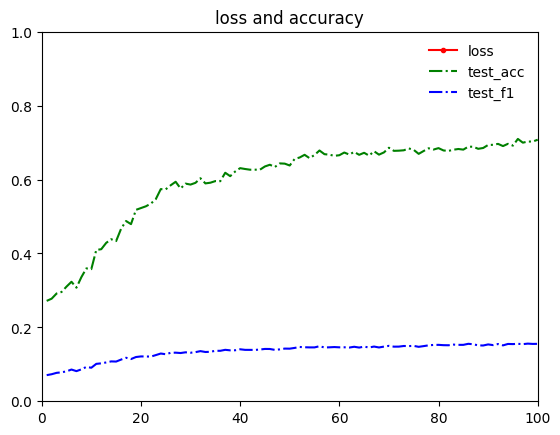

In [82]:
fig = plt.figure()
plt.title('loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, train_accuracy, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [83]:
torch.save(net.state_dict(), 'output/12layer_state_dict.pth')

### 重新训练

In [ ]:
# 18,663,945 total parameters
net.to(device)
num_batches = len(train_iter)
losses, train_accuracy, test_accuracy, valid_accuracy = [], [], [], []
train_f1, test_f1, valid_f1 = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        X, valid_len, y = [v.to(device) for v in data]
        l = criterion(net(X, valid_len).view(-1, num_output), y.view(-1))
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 =evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, test_iter)
    epochvalidacc, epochvalidf1 = evaluate_accuracy_f1(net, validation_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, valid_acc {epochvalidacc:.3f}, '
        f'valid_f1 {epochvalidf1:.3f}, taking {round(end_time - start_time)} seconds.')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
    valid_accuracy.append(epochvalidacc)
    valid_f1.append(epochvalidf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失: {losses[-1]:.3f}, 训练集准确率: {train_accuracy[-1]:.3f}, '
     f'训练集f1: {train_f1[-1]:.3f}, 测试集准确率: {test_accuracy[-1]:.3f}, '
     f'测试集f1: {test_f1[-1]:.3f}, 验证集准确率: {valid_accuracy[-1]:.3f}, '
     f'验证集f1: {valid_f1[-1]:.3f}, 在设备 {device} 上训练 {num_epochs} 周期, 耗时 {total_timecost} s')

100%|██████████| 220/220 [00:51<00:00,  4.31it/s]


epoch 1, loss 155.286, train_acc 0.770, train_f1 0.247, test_acc 0.711, test_f1 0.157, valid_acc 0.779, valid_f1 0.185, taking 109 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.35it/s]


epoch 2, loss 155.132, train_acc 0.766, train_f1 0.245, test_acc 0.701, test_f1 0.155, valid_acc 0.769, valid_f1 0.182, taking 108 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.33it/s]


epoch 3, loss 154.970, train_acc 0.772, train_f1 0.252, test_acc 0.717, test_f1 0.157, valid_acc 0.784, valid_f1 0.189, taking 109 seconds.


100%|██████████| 220/220 [00:51<00:00,  4.31it/s]


epoch 4, loss 154.570, train_acc 0.768, train_f1 0.252, test_acc 0.716, test_f1 0.159, valid_acc 0.774, valid_f1 0.184, taking 109 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.33it/s]


epoch 5, loss 154.259, train_acc 0.769, train_f1 0.251, test_acc 0.717, test_f1 0.158, valid_acc 0.783, valid_f1 0.190, taking 109 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.39it/s]


epoch 6, loss 154.068, train_acc 0.768, train_f1 0.250, test_acc 0.724, test_f1 0.160, valid_acc 0.785, valid_f1 0.191, taking 108 seconds.


100%|██████████| 220/220 [00:51<00:00,  4.31it/s]


epoch 7, loss 154.232, train_acc 0.775, train_f1 0.255, test_acc 0.723, test_f1 0.158, valid_acc 0.788, valid_f1 0.191, taking 109 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.33it/s]


epoch 8, loss 153.691, train_acc 0.778, train_f1 0.260, test_acc 0.724, test_f1 0.157, valid_acc 0.790, valid_f1 0.192, taking 109 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.32it/s]


epoch 9, loss 153.242, train_acc 0.773, train_f1 0.257, test_acc 0.722, test_f1 0.159, valid_acc 0.788, valid_f1 0.193, taking 109 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.32it/s]


epoch 10, loss 153.257, train_acc 0.776, train_f1 0.259, test_acc 0.729, test_f1 0.158, valid_acc 0.789, valid_f1 0.189, taking 108 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.34it/s]


epoch 11, loss 153.073, train_acc 0.773, train_f1 0.255, test_acc 0.720, test_f1 0.155, valid_acc 0.787, valid_f1 0.190, taking 109 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.37it/s]


epoch 12, loss 152.458, train_acc 0.779, train_f1 0.260, test_acc 0.725, test_f1 0.158, valid_acc 0.795, valid_f1 0.192, taking 108 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


epoch 13, loss 152.597, train_acc 0.778, train_f1 0.262, test_acc 0.719, test_f1 0.158, valid_acc 0.786, valid_f1 0.191, taking 109 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.31it/s]


epoch 14, loss 152.787, train_acc 0.777, train_f1 0.262, test_acc 0.729, test_f1 0.160, valid_acc 0.787, valid_f1 0.188, taking 108 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.32it/s]


epoch 15, loss 152.132, train_acc 0.782, train_f1 0.264, test_acc 0.733, test_f1 0.161, valid_acc 0.793, valid_f1 0.193, taking 109 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.34it/s]


epoch 16, loss 152.302, train_acc 0.778, train_f1 0.265, test_acc 0.727, test_f1 0.160, valid_acc 0.795, valid_f1 0.195, taking 109 seconds.


100%|██████████| 220/220 [00:51<00:00,  4.31it/s]


epoch 17, loss 151.836, train_acc 0.779, train_f1 0.262, test_acc 0.728, test_f1 0.158, valid_acc 0.795, valid_f1 0.194, taking 109 seconds.


100%|██████████| 220/220 [00:51<00:00,  4.31it/s]


epoch 18, loss 151.591, train_acc 0.787, train_f1 0.270, test_acc 0.730, test_f1 0.159, valid_acc 0.794, valid_f1 0.193, taking 109 seconds.


100%|██████████| 220/220 [00:51<00:00,  4.31it/s]


epoch 19, loss 151.807, train_acc 0.791, train_f1 0.272, test_acc 0.734, test_f1 0.161, valid_acc 0.799, valid_f1 0.195, taking 109 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.37it/s]


epoch 20, loss 151.402, train_acc 0.782, train_f1 0.266, test_acc 0.732, test_f1 0.160, valid_acc 0.794, valid_f1 0.192, taking 108 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.32it/s]


epoch 21, loss 151.378, train_acc 0.779, train_f1 0.263, test_acc 0.731, test_f1 0.160, valid_acc 0.789, valid_f1 0.189, taking 109 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.32it/s]


epoch 22, loss 151.212, train_acc 0.786, train_f1 0.270, test_acc 0.735, test_f1 0.162, valid_acc 0.794, valid_f1 0.193, taking 108 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.32it/s]


epoch 23, loss 150.730, train_acc 0.791, train_f1 0.270, test_acc 0.736, test_f1 0.163, valid_acc 0.795, valid_f1 0.192, taking 108 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.35it/s]


epoch 24, loss 150.318, train_acc 0.787, train_f1 0.269, test_acc 0.729, test_f1 0.161, valid_acc 0.791, valid_f1 0.193, taking 108 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.35it/s]


epoch 25, loss 150.911, train_acc 0.788, train_f1 0.271, test_acc 0.728, test_f1 0.161, valid_acc 0.789, valid_f1 0.192, taking 108 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.34it/s]


epoch 26, loss 150.750, train_acc 0.787, train_f1 0.274, test_acc 0.724, test_f1 0.162, valid_acc 0.790, valid_f1 0.193, taking 108 seconds.


100%|██████████| 220/220 [00:50<00:00,  4.33it/s]


epoch 27, loss 150.249, train_acc 0.789, train_f1 0.277, test_acc 0.727, test_f1 0.161, valid_acc 0.796, valid_f1 0.195, taking 108 seconds.


 58%|█████▊    | 127/220 [00:29<00:21,  4.34it/s]

### 保存结果

In [36]:
print(f"测试集最佳准确率: {max(test_accuracy):.4f},\n"
    f"测试集最佳F1分数: {max(test_f1):.4f},\n"
    f"验证集最佳准确率: {max(valid_accuracy):.4f},\n"
    f"测试集最佳F1分数: {max(valid_f1):.4f},\n")

测试集最佳准确率: 0.8943,
测试集最佳F1分数: 0.1901,
验证集最佳准确率: 0.8922,
测试集最佳F1分数: 0.1932,



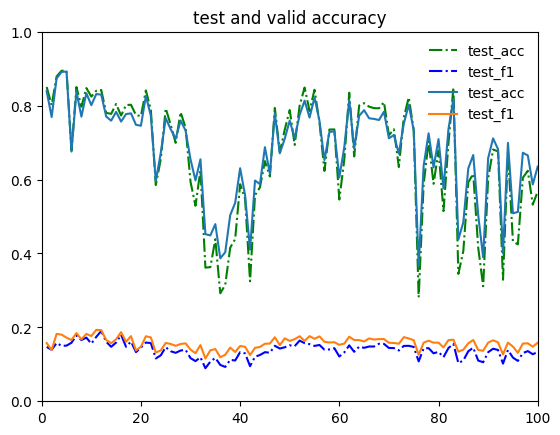

In [38]:
fig = plt.figure()
plt.title('test and valid accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, train_accuracy, test_accuracy, test_f1
# plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.plot(epochs, valid_accuracy, label='test_acc')
plt.plot(epochs, valid_f1, label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [39]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1,
                      "valid_acc": valid_accuracy,
                      "valid_f1": valid_f1,})
result.to_excel(file_path + 'output/2layerba.xlsx')

In [40]:
torch.save(net.state_dict(), 'output/2layerba_100epoch_state_dict.pth')

# 训练 2 (3 layer baseline)

In [52]:
# 带权重的损失函数
tags_cnt = Counter(t for tags in dataset['train']['tags'] for t in tags)
weights = [max(tags_cnt.values()) / tags_cnt[k] for k in sorted(tags_cnt.keys())]
print(weights)
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(reduction='none', weight=class_weights)

[1.0, 26.827242524916944, 49.32373472949389, 25.693181818181817, 37.45030918727915, 23.75, 45.78158747300216, 146.8181818181818, 146.56439066551425]


In [53]:
# trainer = torch.optim.Adam(params=net.parameters(), lr=lr)
# 为不同层赋予不同的学习率
forward_params = [
                param for name, param in net.named_parameters()
                if name != "embedding.weight"]
trainer = torch.optim.Adam(
                        [{'params': net.embedding.parameters()},
                         {'params': forward_params, 'lr': lr * 10}], lr=lr)

In [54]:
# 21,814,281 total parameters
net.to(device)
num_batches = len(train_iter)
losses, train_accuracy, test_accuracy, valid_accuracy = [], [], [], []
train_f1, test_f1, valid_f1 = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        X, valid_len, y = [v.to(device) for v in data]
        l = criterion(net(X, valid_len).view(-1, num_output), y.view(-1))
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 =evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, test_iter)
    epochvalidacc, epochvalidf1 = evaluate_accuracy_f1(net, validation_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, valid_acc {epochvalidacc:.3f}, '
        f'valid_f1 {epochvalidf1:.3f}, taking {round(end_time - start_time)} seconds.')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
    valid_accuracy.append(epochvalidacc)
    valid_f1.append(epochvalidf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失: {losses[-1]:.3f}, 训练集准确率: {train_accuracy[-1]:.3f}, '
     f'训练集f1: {train_f1[-1]:.3f}, 测试集准确率: {test_accuracy[-1]:.3f}, '
     f'测试集f1: {test_f1[-1]:.3f}, 验证集准确率: {valid_accuracy[-1]:.3f}, '
     f'验证集f1: {valid_f1[-1]:.3f}, 在设备 {device} 上训练 {num_epochs} 周期, 耗时 {total_timecost} s')

100%|██████████| 220/220 [00:04<00:00, 49.46it/s]


epoch 1, loss 321.252, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.96it/s]


epoch 2, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.73it/s]


epoch 3, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.83it/s]


epoch 4, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.74it/s]


epoch 5, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.97it/s]


epoch 6, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.90it/s]


epoch 7, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.95it/s]


epoch 8, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.82it/s]


epoch 9, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.98it/s]


epoch 10, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.06it/s]


epoch 11, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.23it/s]


epoch 12, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.07it/s]


epoch 13, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.22it/s]


epoch 14, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.66it/s]


epoch 15, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.61it/s]


epoch 16, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.63it/s]


epoch 17, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.02it/s]


epoch 18, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.54it/s]


epoch 19, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.93it/s]


epoch 20, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.26it/s]


epoch 21, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 54.00it/s]


epoch 22, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 53.14it/s]


epoch 23, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 52.13it/s]


epoch 24, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.89it/s]


epoch 25, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 52.50it/s]


epoch 26, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.62it/s]


epoch 27, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.32it/s]


epoch 28, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.26it/s]


epoch 29, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.82it/s]


epoch 30, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 49.19it/s]


epoch 31, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.51it/s]


epoch 32, loss 307.637, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.86it/s]


epoch 33, loss 307.270, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.23it/s]


epoch 34, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.33it/s]


epoch 35, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.96it/s]


epoch 36, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.10it/s]


epoch 37, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.28it/s]


epoch 38, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.14it/s]


epoch 39, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.02it/s]


epoch 40, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.42it/s]


epoch 41, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.78it/s]


epoch 42, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.89it/s]


epoch 43, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.80it/s]


epoch 44, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.97it/s]


epoch 45, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.95it/s]


epoch 46, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.90it/s]


epoch 47, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.96it/s]


epoch 48, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.16it/s]


epoch 49, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.06it/s]


epoch 50, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.12it/s]


epoch 51, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.26it/s]


epoch 52, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.71it/s]


epoch 53, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 52.04it/s]


epoch 54, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.78it/s]


epoch 55, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.01it/s]


epoch 56, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.18it/s]


epoch 57, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.22it/s]


epoch 58, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.90it/s]


epoch 59, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.14it/s]


epoch 60, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.21it/s]


epoch 61, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.25it/s]


epoch 62, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.09it/s]


epoch 63, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.92it/s]


epoch 64, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.46it/s]


epoch 65, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.31it/s]


epoch 66, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.11it/s]


epoch 67, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.22it/s]


epoch 68, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.29it/s]


epoch 69, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.54it/s]


epoch 70, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 48.76it/s]


epoch 71, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.05it/s]


epoch 72, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.10it/s]


epoch 73, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.25it/s]


epoch 74, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.12it/s]


epoch 75, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.76it/s]


epoch 76, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.61it/s]


epoch 77, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.53it/s]


epoch 78, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.32it/s]


epoch 79, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.99it/s]


epoch 80, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.98it/s]


epoch 81, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.84it/s]


epoch 82, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.80it/s]


epoch 83, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.01it/s]


epoch 84, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.73it/s]


epoch 85, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.66it/s]


epoch 86, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.00it/s]


epoch 87, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.81it/s]


epoch 88, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.79it/s]


epoch 89, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.76it/s]


epoch 90, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.21it/s]


epoch 91, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.24it/s]


epoch 92, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.99it/s]


epoch 93, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.46it/s]


epoch 94, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.65it/s]


epoch 95, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.61it/s]


epoch 96, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.66it/s]


epoch 97, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 47.65it/s]


epoch 98, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 50.64it/s]


epoch 99, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.


100%|██████████| 220/220 [00:04<00:00, 51.11it/s]


epoch 100, loss 307.271, train_acc 0.960, train_f1 0.109, test_acc 0.961, test_f1 0.109, valid_acc 0.956, valid_f1 0.109, taking 6 seconds.
Training is finished.
训练损失: 307.271, 训练集准确率: 0.960, 训练集f1: 0.109, 测试集准确率: 0.961, 测试集f1: 0.109, 验证集准确率: 0.956, 验证集f1: 0.109, 在设备 cuda 上训练 100 周期, 耗时 602 s


### 保存结果

In [55]:
print(f"测试集最佳准确率: {max(test_accuracy):.4f},\n"
    f"测试集最佳F1分数: {max(test_f1):.4f},\n"
    f"验证集最佳准确率: {max(valid_accuracy):.4f},\n"
    f"测试集最佳F1分数: {max(valid_f1):.4f},\n")

测试集最佳准确率: 0.9611,
测试集最佳F1分数: 0.1089,
验证集最佳准确率: 0.9563,
测试集最佳F1分数: 0.1086,



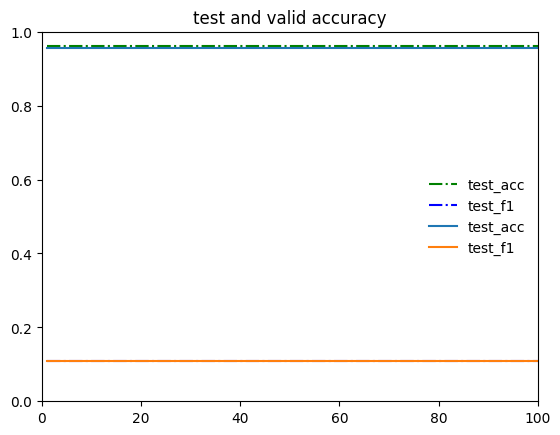

In [56]:
fig = plt.figure()
plt.title('test and valid accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, train_accuracy, test_accuracy, test_f1
# plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.plot(epochs, valid_accuracy, label='test_acc')
plt.plot(epochs, valid_f1, label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [ ]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1,
                      "valid_acc": valid_accuracy,
                      "valid_f1": valid_f1,})
result.to_excel(file_path + 'output/3layerba.xlsx')

In [57]:
torch.save(net.state_dict(), 'output/3layerba_100epoch_state_dict.pth')